# Getting the data

In [165]:
from pyspark import SparkContext, SparkConf
from math import sqrt,log
from random import randint, random
import matplotlib.pyplot as plt

%matplotlib inline

sc = SparkContext.getOrCreate()
sc.stop()

conf = SparkConf().setAppName("kmeans").setMaster("local[*]")
sc = SparkContext(conf=conf)

* Getting data from S-sets : https://cs.joensuu.fi/sipu/datasets/
* Using the s1 dataset

In [166]:
s1 = sc.textFile("../data/s1.txt")


def extract_split(x):
    splits = x.split('    ')
    return (int(splits[1]), int(splits[2]))

s1 = s1.flatMap(lambda x: x.split('\n')).map(extract_split)



In [167]:
s1.takeSample(False, 20)

[(137657, 611252),
 (328586, 551385),
 (596179, 529556),
 (617954, 395504),
 (391530, 398743),
 (804251, 329956),
 (388806, 569524),
 (419520, 778231),
 (669748, 863109),
 (809779, 663654),
 (523329, 404632),
 (850787, 125678),
 (807278, 566392),
 (117089, 561455),
 (668482, 358452),
 (824475, 518063),
 (142265, 546135),
 (322209, 547247),
 (621989, 394856),
 (160222, 380591)]

# Kmeans ++ intitialization

In [168]:
cluster1_center = s1.takeSample(False, 1)[0]

In [169]:
s1_map = s1.map(lambda x : x + cluster1_center)
s1_map.takeSample(False,20)

[(511106, 122518, 560362, 567914),
 (825141, 535997, 560362, 567914),
 (677896, 867053, 560362, 567914),
 (871597, 185239, 560362, 567914),
 (185919, 363092, 560362, 567914),
 (838609, 140215, 560362, 567914),
 (608601, 418450, 560362, 567914),
 (870337, 534303, 560362, 567914),
 (617573, 386848, 560362, 567914),
 (226949, 889283, 560362, 567914),
 (417494, 392231, 560362, 567914),
 (863859, 546898, 560362, 567914),
 (418086, 394699, 560362, 567914),
 (117089, 561455, 560362, 567914),
 (637594, 420311, 560362, 567914),
 (804332, 319006, 560362, 567914),
 (835648, 756631, 560362, 567914),
 (671919, 571761, 560362, 567914),
 (469139, 810971, 560362, 567914),
 (265299, 859533, 560362, 567914)]

In [170]:
def compute_distance(xi_indexes, yi_indexes):
    def bar(row):
        sum = 0
        for i in range(len(xi_indexes)):
            sum += (row[yi_indexes[i]] - row[xi_indexes[i]]) ** 2
        distance = sqrt(sum)
        return row + (distance,)
    return bar


In [191]:
def reduceMax(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  min(dist_x1)
        mindist_x2 = min(dist_x2)
        
        if(mindist_x1 == 0):
            print("FOUND ZERO")
            return x2
        
        if(mindist_x2 == 0):
            print("FOUND ZERO")
            return x1
        

        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom



In [172]:
def reduceMaxSum(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)
        mindist_x2 = sum(dist_x2)
        
        
        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom



In [173]:
def reduceMaxAverage(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)/len(dist_x1)
        mindist_x2 = sum(dist_x2)/len(dist_x2)
        
        
        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom



In [ ]:
def reduceMaxAverage(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  sum(dist_x1)/len(dist_x1)
        mindist_x2 = sum(dist_x2)/len(dist_x2)
        
        
        if(mindist_x1 > mindist_x2):
            return x1
        else:
            return x2
        
        
    return reduce_custom



In [174]:
def reduceMaxWithRandom(dist_indexes):
    def reduce_custom(x1,x2):
        dist_x1 = []
        dist_x2 = []
        for idx in dist_indexes:
            dist_x1.append(x1[idx])
            dist_x2.append(x2[idx])
        
        mindist_x1 =  min(dist_x1)
        mindist_x2 = min(dist_x2)
        
        
        if(mindist_x1 != 0):
            drawx1 = log(mindist_x1) * random() 
        else:
            drawx1 = 0
        if(mindist_x2 != 0):
            drawx2 = log(mindist_x2) * random()
        else:
            drawx2 = 0
            
            
        if(drawx1 > drawx2):
            return x1
        else:
            return x2
        
            
    return reduce_custom

In [175]:
def compute_average(list_reduce, coord_indexes):
    result = ()
    for idx in coord_indexes:
        coord_list = [reduce_tuple[1][idx] for reduce_tuple in list_reduce]
        average = sum(coord_list)/len(coord_list)
        result += (average,)
    return result
        

In [176]:
def drawGraph(data, cluster_centers):
    datalist = data.collect()
    plt.figure()
    x = [point[0] for point in datalist]
    y = [point[1] for point in datalist]
    
    x_clusters = [point[0] for point in cluster_centers]
    y_clusters = [point[1] for point in cluster_centers]
    
    plt.plot(x,y,'bs', x_clusters, y_clusters, 'r^')

In [177]:
def initCluster(data,num_clusters,num_features, reducer, cluster_centers, visualize=False):
    xi_indexes = [idx for idx in range(0,num_features)]
    yi_indexes = [idx for idx in range(num_features, num_features*2)]
    coord_indexes = [idx for idx in range(num_features)]
    dist_indexes = [num_features*2]
    current_clust = 2
    
    '''
    print("Initial xi_indexes : ", xi_indexes)
    print("Initial yi_indexes : ", yi_indexes)
    print("Initial coord_indexes : ",coord_indexes)
    print("Initial dist_indexes : ", dist_indexes)
    print("Intial current_clust :", current_clust)
    print("\n")
    '''
    
    for _ in range(num_clusters-1):
        
        
        data = data.map(compute_distance(xi_indexes, yi_indexes))
        
        reduce_tuple = data.reduce(reducer(dist_indexes=dist_indexes))
                
            
        new_cluster_point = tuple(reduce_tuple[i] for i in coord_indexes)
                                  
        cluster_centers.append(new_cluster_point)
                                  
        #print("Computing center of cluster n° {}".format(current_clust))
        print("New cluster point : {}".format(new_cluster_point))
        
        data = data.map(lambda x:(x + new_cluster_point))
        
        
        if visualize:
            #Assume that data is 2D, and coord is 0,1
            drawGraph(data, cluster_centers)
        
        #Update of variables
        current_clust += 1
        dist_indexes.append(current_clust*num_features + current_clust - 2)
        yi_indexes = [old_value + num_features + 1 for old_value in yi_indexes]
        
        #print("New yi indexes : {}".format(yi_indexes))
        #print("New dist_indexes : {}".format(dist_indexes))
        print("\n")

    return data, cluster_centers
        


Initial cluster center :  (336787, 538925) 

New cluster point : (895835, 123485)


New cluster point : (878690, 739021)


New cluster point : (854996, 81095)


New cluster point : (878690, 739021)


New cluster point : (854996, 81095)




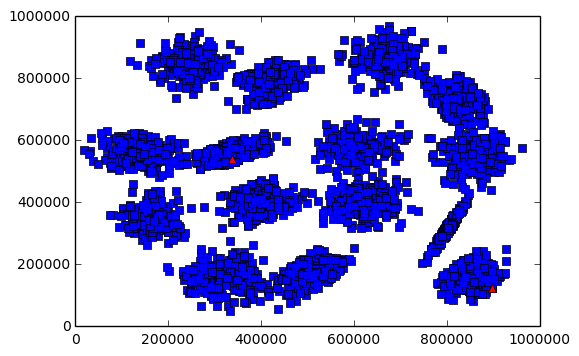

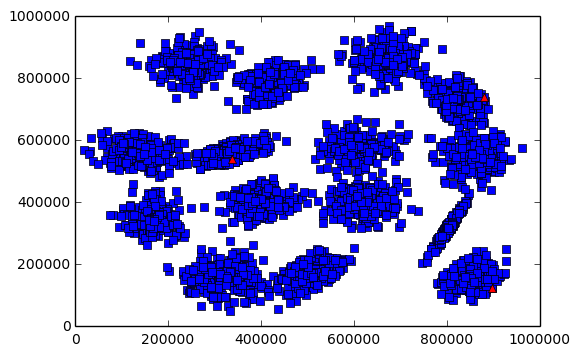

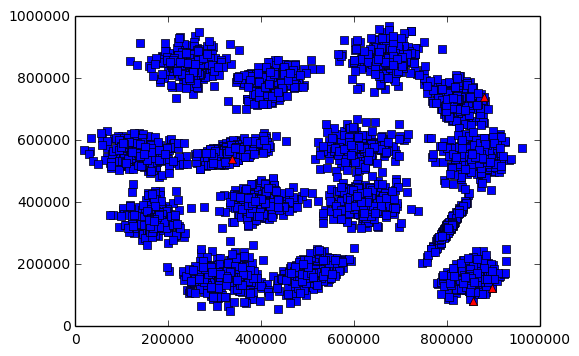

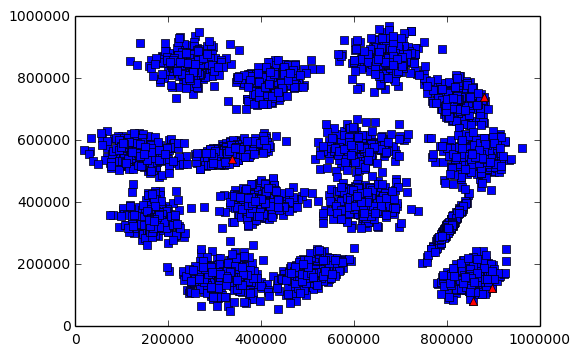

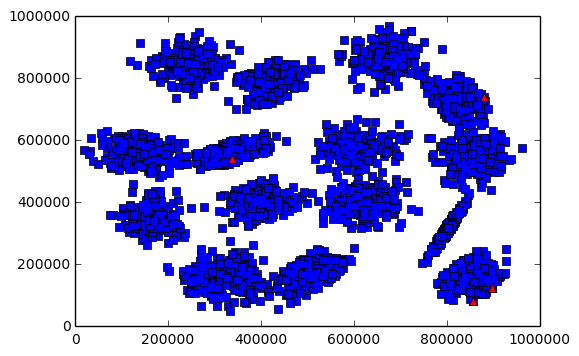

In [193]:
cluster1_center = s1.takeSample(False, 1)[0]
cluster_centers = [cluster1_center]
print("Initial cluster center : ",cluster1_center, "\n")
s1_map = s1.map(lambda x : x + cluster1_center)
s1_map_clustered, cluster_centers = initCluster(s1_map, num_features=2,num_clusters=6, reducer=reduceMax, cluster_centers=cluster_centers, visualize=True)


Initial cluster center :  (862002, 534006) 

New cluster point : (684091, 842566)


New cluster point : (577773, 434308)


New cluster point : (618053, 357534)


New cluster point : (677362, 853471)


New cluster point : (599647, 858702)


New cluster point : (577773, 434308)


New cluster point : (615239, 317684)


New cluster point : (684091, 842566)


New cluster point : (599647, 858702)




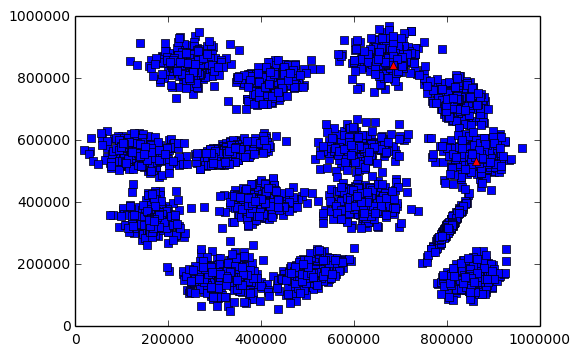

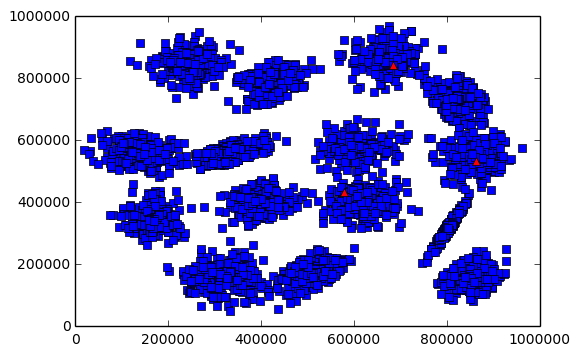

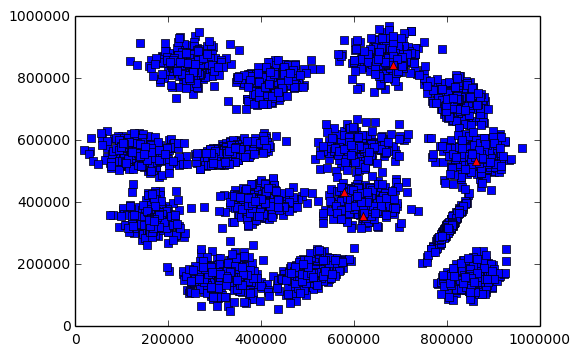

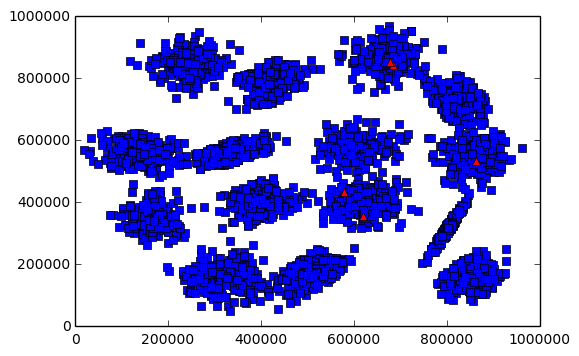

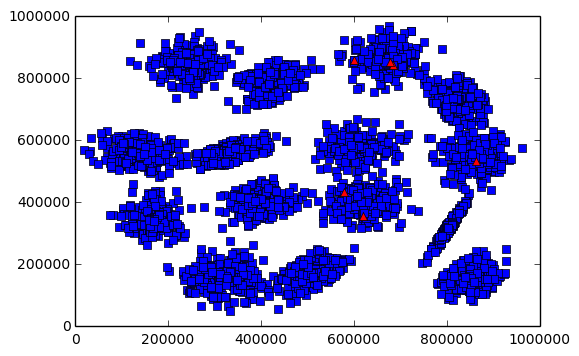

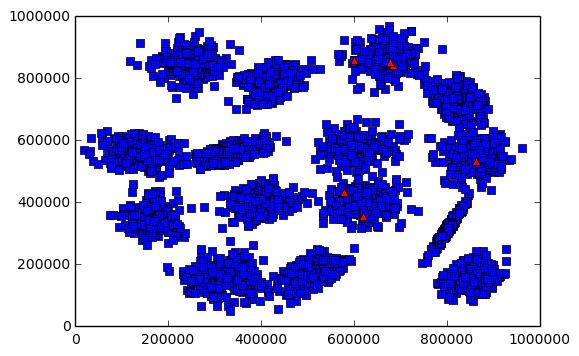

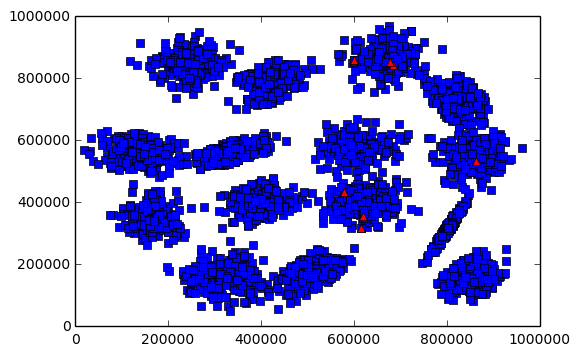

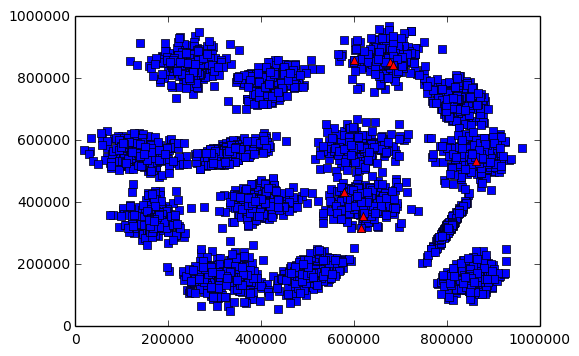

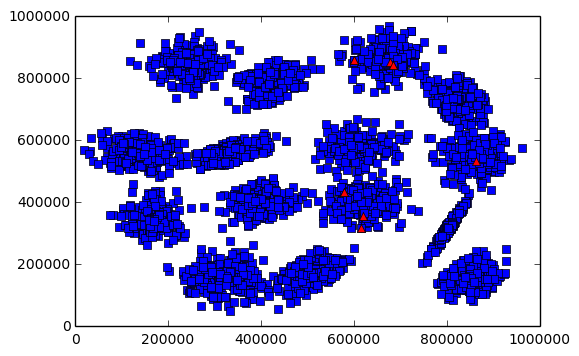

In [179]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxWithRandom,  cluster_centers=cluster_centers, visualize=True)


Initial cluster center :  (862002, 534006) 

New cluster point : (19835, 570290)


New cluster point : (854996, 81095)


New cluster point : (139601, 914203)


New cluster point : (854996, 81095)


New cluster point : (139601, 914203)


New cluster point : (854996, 81095)


New cluster point : (139601, 914203)


New cluster point : (854996, 81095)


New cluster point : (139601, 914203)




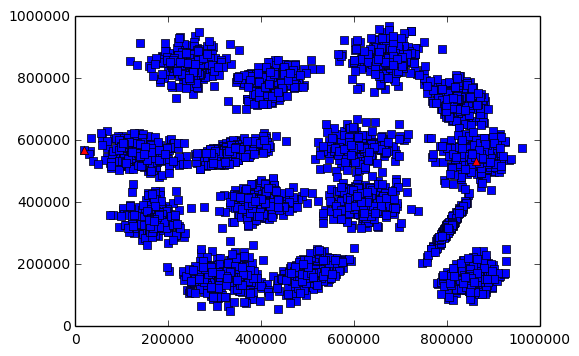

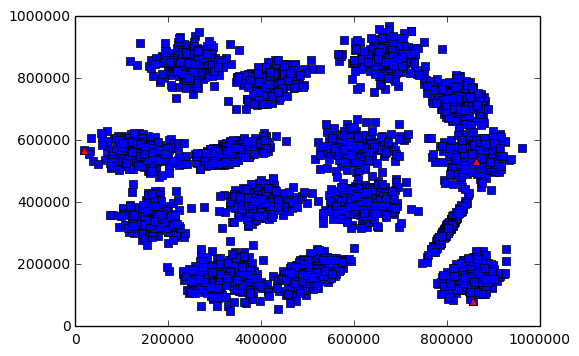

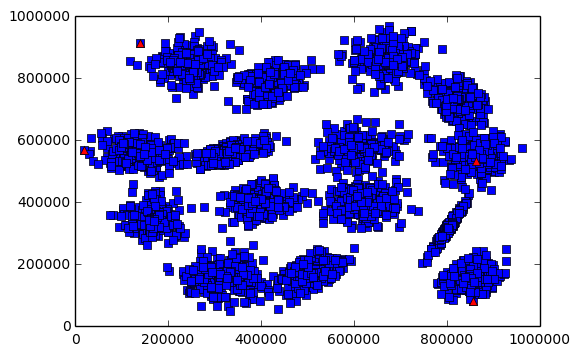

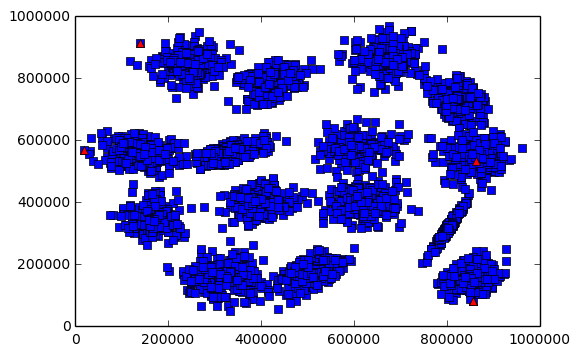

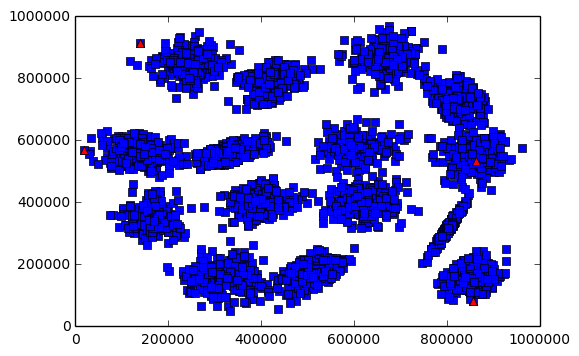

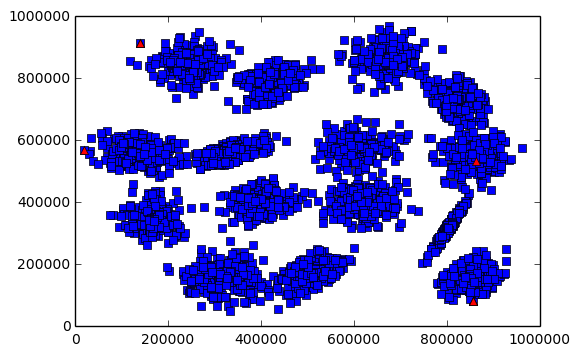

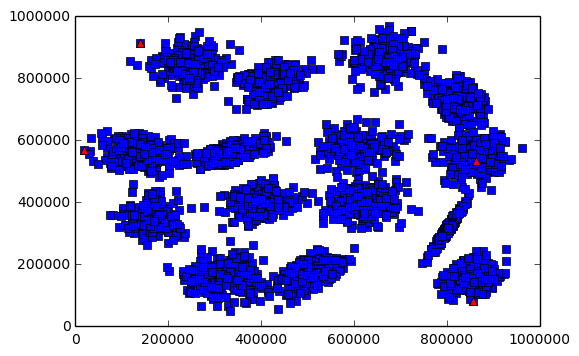

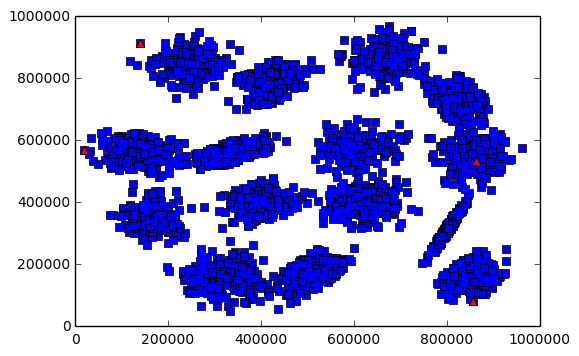

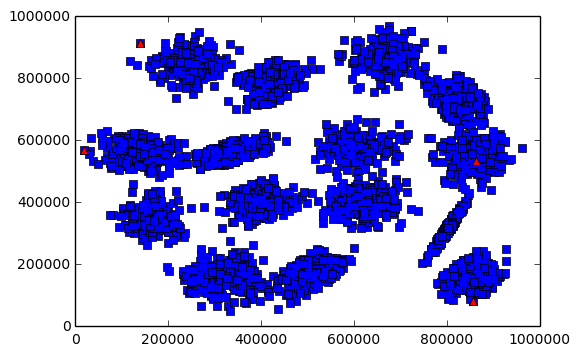

In [180]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxSum,  cluster_centers=cluster_centers, visualize=True)


Initial cluster center :  (862002, 534006) 

New cluster point : (19835, 570290)


New cluster point : (854996, 81095)


New cluster point : (139601, 914203)


New cluster point : (854996, 81095)


New cluster point : (139601, 914203)


New cluster point : (854996, 81095)


New cluster point : (139601, 914203)


New cluster point : (854996, 81095)


New cluster point : (139601, 914203)




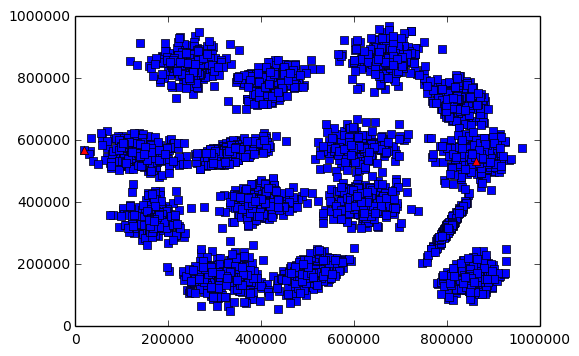

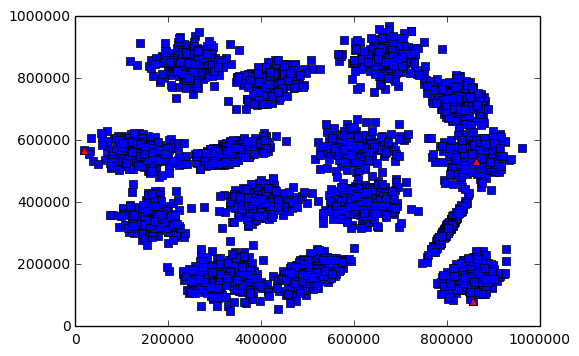

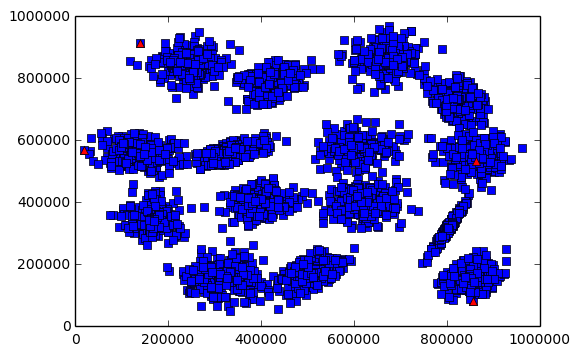

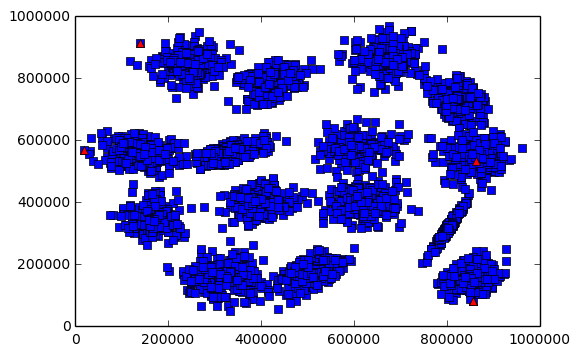

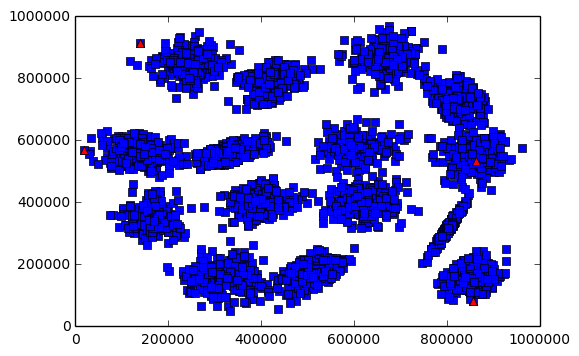

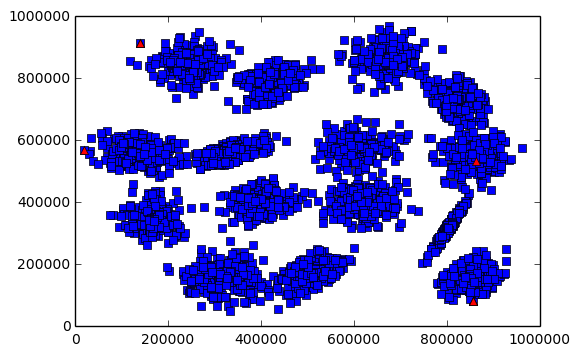

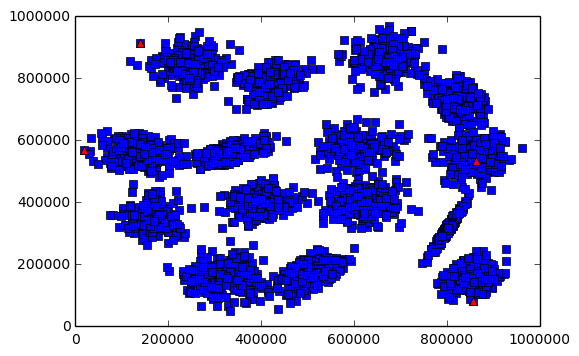

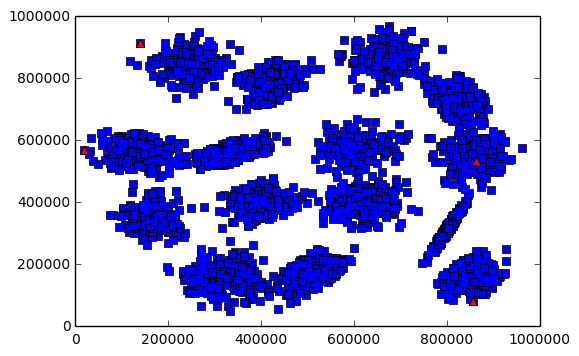

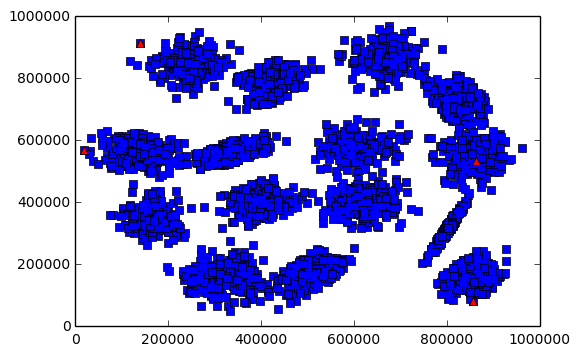

In [181]:
print("Initial cluster center : ",cluster1_center, "\n")
cluster_centers = [cluster1_center]
s1_map_clustered2 = initCluster(s1_map, num_features=2,num_clusters=10, reducer=reduceMaxAverage,  cluster_centers=cluster_centers, visualize=True)
